In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D,LeakyReLU
import matplotlib.pyplot as plt
from mat2json import loadMat
from sklearn.model_selection import train_test_split

In [2]:
B0005 = loadMat('B0005.mat') # load the battery

In [3]:
def extract_discharge(Battery): 
    cap = [] 
    i = 1
    for Bat in Battery: 
        if Bat['cycle'] == 'discharge':
            cap.append((Bat['data']['Capacity'][0])) 
            i+=1
    return cap

In [4]:
cap5 = extract_discharge(B0005)

In [6]:
A = extract_charge_VIT(B0005) # Get the value of A
InitC = 1.85;# get the value of InitC
cap5 = extract_discharge(B0005); # Get the cap5 

In [7]:
# Scaling the data
def minmax_norm(A,InitC,cap):
    r = np.max(A) - np.min(A); 
    xData = (A - np.min(A))/r; 
    comp = len(A) - len(cap);
    yData = np.vstack((InitC*np.ones((comp, 1)), np.reshape(cap5, (len(cap5), 1)))) 
    ym = np.min(yData);
    yr = np.max(yData) - np.min(yData);
    yData = (yData - ym)/yr;
    return xData, yData, ym, yr          


In [8]:
xData, yData, ym, yr = minmax_norm(A,InitC,cap5)

In [12]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size = 0.20,shuffle = False)# split the data into train and test


In [13]:
# Building the model using Conv2D
input_shape = (1,30,1)
model = Sequential()
model.add(Conv2D(30, kernel_size=(1, 2), strides=(1, 1), input_shape=input_shape))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(10, kernel_size=(1, 2),strides=(1, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 29, 30)         90        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 29, 30)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 28, 10)         610       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 28, 10)         0         
_________________________________________________________________
flatten (Flatten)            (None, 280)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 281       
Total params: 981
Trainable params: 981
Non-trainable params: 0
__________________________________________________________

In [14]:
model.compile(loss='mean_squared_error',optimizer='adam',  metrics = ['accuracy'])

In [15]:
model.fit(X_train,y_train,epochs=300, batch_size=16, verbose=1,validation_data=(X_test,y_test))

Epoch 1/300
8/8 [==============================] - 0s 19ms/step - loss: 0.3757 - accuracy: 0.0088 - val_loss: 0.2208 - val_accuracy: 0.0000e+00
Epoch 2/300
8/8 [==============================] - 0s 5ms/step - loss: 0.1566 - accuracy: 0.0088 - val_loss: 0.0942 - val_accuracy: 0.0000e+00
Epoch 3/300
8/8 [==============================] - 0s 5ms/step - loss: 0.0921 - accuracy: 0.0088 - val_loss: 0.1030 - val_accuracy: 0.0000e+00
Epoch 4/300
8/8 [==============================] - 0s 5ms/step - loss: 0.1029 - accuracy: 0.0088 - val_loss: 0.0849 - val_accuracy: 0.0000e+00
Epoch 5/300
8/8 [==============================] - 0s 5ms/step - loss: 0.0783 - accuracy: 0.0088 - val_loss: 0.0723 - val_accuracy: 0.0000e+00
Epoch 6/300
8/8 [==============================] - 0s 5ms/step - loss: 0.0701 - accuracy: 0.0177 - val_loss: 0.0677 - val_accuracy: 0.0000e+00
Epoch 7/300
8/8 [==============================] - 0s 5ms/step - loss: 0.0657 - accuracy: 0.0177 - val_loss: 0.0629 - val_accuracy: 0.0000e+0

In [16]:
y_predict = model.predict(X_test) # predictions on test data

In [17]:
# calculate the prediction error
mape = np.sum(abs(y_test[:,0]- y_predict))/np.size(y_test)
print(mape)

0.025131108479421037


In [18]:
y_predict_actual = y_predict*yr+ ym

In [19]:
y_test_actual = y_test[:,0]*yr + ym

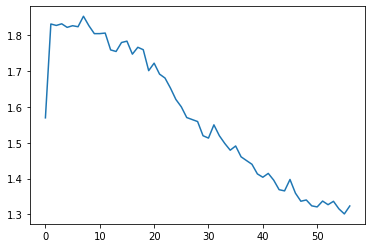

In [20]:
plt.plot(y_predict_actual)

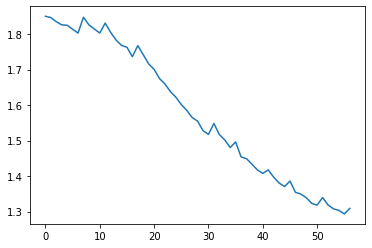

In [21]:
plt.plot(y_test_actual)

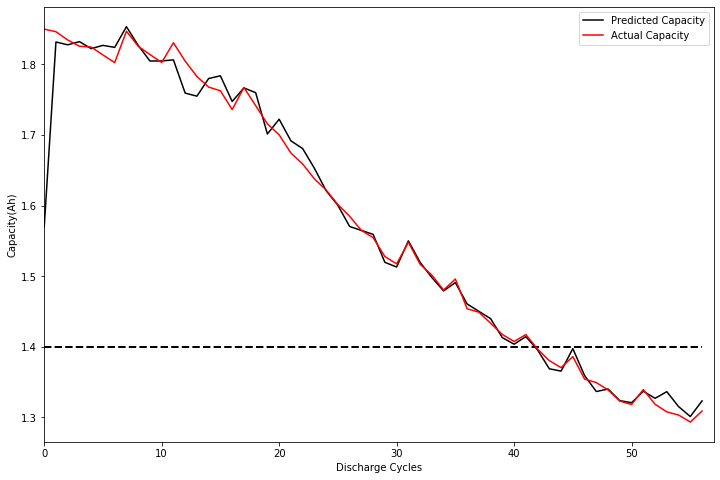

In [22]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(np.arange(57), 1.4*np.ones((57, 1)),'k--',linewidth = 2)
ax.plot(y_predict_actual, color='black',label='Predicted Capacity')
ax.plot(y_test_actual, color='red',label='Actual Capacity')
ax.set(xlabel='Discharge Cycles', ylabel='Capacity(Ah)')
ax.set_xlim([0,57])
ax.legend()